# Import

In [47]:
!pip install catboost optuna interpret

In [48]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import ast

# Read

In [49]:
df = pd.read_parquet("/content/drive/MyDrive/raw_dataframe.parquet", engine="pyarrow")
df.fillna(0, inplace=True)

In [50]:
df['auto_payment_true'] = (df['auto_payment'] == True).astype(int)
df['auto_payment_false'] = (df['auto_payment'] == False).astype(int)
df['auto_payment_unknown'] = df['auto_payment'].isnull().astype(int)
df.drop(columns=['auto_payment'], inplace=True)
df.head()

,id,age,tenure,service_type,avg_call_duration,data_usage,roaming_usage,monthly_charge,overdue_payments,avg_top_up_count,call_drops,customer_support_calls,satisfaction_score,apps,churn,auto_payment_true,auto_payment_false,auto_payment_unknown
0,51893f29-e6c2-45d3-807c-e1280d3d7b90,18,53.0,Prepaid,106.74,139.72,47.31,59.45,0,25,18.0,13,1.34,[],False,0,1,0
1,a568caf1-d851-4847-a9f5-20ef9017fa92,26,15.0,Prepaid,31.55,12.14,21.52,1221.65,0,51,8.0,3,2.57,[],False,0,1,0
2,c611bf0e-a013-44dc-9939-bd33dab16d14,32,152.0,Postpaid,30.64,10.17,31.11,1170.45,0,0,13.0,10,8.02,[],False,1,0,0
3,9284b7b8-a4ef-49a7-9fa4-333954491f57,33,35.0,Prepaid,0.00,0.00,36.03,2418.91,0,19,7.0,11,5.96,[RitimGo],False,0,1,0
4,e205b674-a6e6-43c5-aed7-9497c37c5c82,18,243.0,Prepaid,85.62,164.79,46.40,1518.19,0,99,15.0,6,8.29,[],False,0,1,0


In [51]:
product_df = df[["id","monthly_charge","churn"]]
df.head()

,id,age,tenure,service_type,avg_call_duration,data_usage,roaming_usage,monthly_charge,overdue_payments,avg_top_up_count,call_drops,customer_support_calls,satisfaction_score,apps,churn,auto_payment_true,auto_payment_false,auto_payment_unknown
0,51893f29-e6c2-45d3-807c-e1280d3d7b90,18,53.0,Prepaid,106.74,139.72,47.31,59.45,0,25,18.0,13,1.34,[],False,0,1,0
1,a568caf1-d851-4847-a9f5-20ef9017fa92,26,15.0,Prepaid,31.55,12.14,21.52,1221.65,0,51,8.0,3,2.57,[],False,0,1,0
2,c611bf0e-a013-44dc-9939-bd33dab16d14,32,152.0,Postpaid,30.64,10.17,31.11,1170.45,0,0,13.0,10,8.02,[],False,1,0,0
3,9284b7b8-a4ef-49a7-9fa4-333954491f57,33,35.0,Prepaid,0.00,0.00,36.03,2418.91,0,19,7.0,11,5.96,[RitimGo],False,0,1,0
4,e205b674-a6e6-43c5-aed7-9497c37c5c82,18,243.0,Prepaid,85.62,164.79,46.40,1518.19,0,99,15.0,6,8.29,[],False,0,1,0


In [52]:

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'apps' column
apps_encoded = mlb.fit_transform(df['apps'])

# Create a DataFrame from the encoded matrix with appropriate column names
apps_df = pd.DataFrame(apps_encoded, columns=mlb.classes_, index=df.index)

# Concatenate the new one-hot encoded columns with the original DataFrame,
# dropping the original 'apps' column if desired
df = pd.concat([df.drop('apps', axis=1), apps_df], axis=1)



In [53]:
# df.drop("apps", axis=1, inplace=True)

In [54]:
df = df.drop("id", axis=1)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   age                     int64  
 1   tenure                  float64
 2   service_type            object 
 3   avg_call_duration       float64
 4   data_usage              float64
 5   roaming_usage           float64
 6   monthly_charge          float64
 7   overdue_payments        int64  
 8   avg_top_up_count        int64  
 9   call_drops              float64
 10  customer_support_calls  int64  
 11  satisfaction_score      float64
 12  churn                   bool   
 13  auto_payment_true       int64  
 14  auto_payment_false      int64  
 15  auto_payment_unknown    int64  
 16  CüzdanX                 int64  
 17  HızlıPazar              int64  
 18  Konuşalım               int64  
 19  RitimGo                 int64  
 20  İzleGo                  int64  
dtypes: bool(1), float64(7), int64(

In [56]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))

,age,tenure,avg_call_duration,data_usage,roaming_usage,monthly_charge,overdue_payments,avg_top_up_count,call_drops,customer_support_calls,satisfaction_score,auto_payment_true,auto_payment_false,auto_payment_unknown,CüzdanX,HızlıPazar,Konuşalım,RitimGo,İzleGo
count,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00,10000000.00
mean,30.38,157.86,38.34,95.07,20.00,725.17,1.67,17.52,6.67,10.00,5.50,0.33,0.67,0.00,0.01,0.01,0.20,0.10,0.03
std,11.40,94.96,39.97,60.32,20.00,601.12,1.83,29.48,6.83,6.06,2.60,0.47,0.47,0.00,0.10,0.10,0.40,0.30,0.17
min,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,20.00,78.00,0.00,42.23,0.00,305.24,0.00,0.00,0.00,5.00,3.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,28.00,156.00,26.13,94.79,14.99,472.29,1.00,0.00,5.00,10.00,5.50,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,234.00,73.06,147.42,37.49,1003.24,3.00,29.00,13.00,15.00,7.75,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
max,80.00,754.00,120.00,200.00,60.00,2500.00,5.00,100.00,20.00,20.00,10.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


In [57]:
# Create a DataFrame for rows where service_type is 'Broadband'
df_broadband = df[df["service_type"] == "Broadband"].copy()
df_broadband.drop("service_type", axis=1, inplace=True)


# Create a DataFrame for rows where service_type is 'Postpaid'
df_postpaid = df[df["service_type"] == "Postpaid"].copy()
df_postpaid.drop("service_type", axis=1, inplace=True)

# Create a DataFrame for rows where service_type is 'Prepaid'
df_prepaid = df[df["service_type"] == "Prepaid"].copy()
df_prepaid.drop("service_type", axis=1, inplace=True)


In [58]:
# def remove_outliers_iqr(data, column, factor=1.5):
#     """
#     Remove outliers from a DataFrame column using the IQR method.

#     Parameters:
#         data (pd.DataFrame): The DataFrame containing the data.
#         column (str): The name of the column to process.
#         factor (float): The multiplier for the IQR (default is 1.5).

#     Returns:
#         pd.DataFrame: DataFrame with outliers removed for the specified column.
#     """
#     Q1 = data[column].quantile(0.25)
#     Q3 = data[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - factor * IQR
#     upper_bound = Q3 + factor * IQR
#     # Keep only the data within the bounds
#     filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
#     return filtered_data

# columns_to_clean = [
#     'age', 'tenure', 'avg_call_duration', 'data_usage',
#     'roaming_usage', 'monthly_charge', 'call_drops'
# ]

# for col in columns_to_clean:
#     df = remove_outliers_iqr(df, col)

In [59]:
# df.drop(["customer_support_calls",'avg_call_duration', 'data_usage', 'roaming_usage', 'monthly_charge', 'call_drops'], axis=1, inplace=True)
# df.drop(["avg_call_duration", "data_usage", "roaming_usage", "HızlıPazar", "CüzdanX", "service_type_Prepaid"], axis=1, inplace=True)

# Model

In [60]:
# # Here we drop the "id" column because it’s an identifier.
X = df.drop(columns=['churn'])
y = df['churn']

In [61]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# # Install PyCaret if you haven't already (uncomment the next line if needed)
# # !pip install pycaret

# # import pandas as pd
# from pycaret.classification import *

# # 1. Load the dataset from Google Drive
# # df = pd.read_csv("/content/drive/MyDrive/dataframe.csv")

# # (Optional) Preview the data
# print(df.head())

# # 2. Define the target variable.
# # Replace 'target' with the actual name of your target column.
# target_variable = 'churn'

# # 3. Initialize the PyCaret classification environment.
# #    - fix_imbalance=True enables automatic handling of imbalanced datasets.
# #    - session_id is set for reproducibility.
# clf_setup = setup(data=df,
#                   target=target_variable,
#                   session_id=123,
#                   fix_imbalance=True,   # set to False if you want interactive questions
#                   verbose=True,
#                   use_gpu=True)  # shows setup details

# # 4. Compare multiple models.
# #    Here we sort by the F1 score because it is crucial when dealing with unbalanced classes.
# best_model = compare_models(sort='F1', include=['rf', 'lightgbm', 'xgboost', 'catboost'])

# # 5. Evaluate the best model.
# #    This will open an interactive dashboard (if using a notebook) with various evaluation plots,
# #    including metrics such as Recall and F1.
# evaluate_model(best_model)

# # 6. (Optional) Tune the best model to further optimize its performance based on F1 score.
# tuned_model = tune_model(best_model, optimize='F1')

# # 7. Finalize the tuned model (this step prepares the model for deployment).
# final_model = finalize_model(tuned_model)

# # 8. (Optional) View the leaderboard table containing various metrics including Recall and F1.
# results = pull()  # pulls the latest displayed table from PyCaret
# print(results)

# # 9. (Optional) Use the finalized model for predictions on new or hold-out data.
# # For example, if you have a test dataset:
# # test_df = pd.read_csv("/content/drive/MyDrive/test_dataframe.csv")
# # predictions = predict_model(final_model, data=test_df)
# # print(predictions.head())


# Model

### Light

Processing Broadband Data:
Accuracy: 0.6245003699851256
              precision    recall  f1-score   support

       False       1.00      0.62      0.77    664288
        True       0.00      0.58      0.01      1955

    accuracy                           0.62    666243
   macro avg       0.50      0.60      0.39    666243
weighted avg       1.00      0.62      0.77    666243

F1 Score: 0.008952835196526617
Precision: 0.004511356241441398
Recall: 0.578005115089514
AUC: 0.6199528812665482


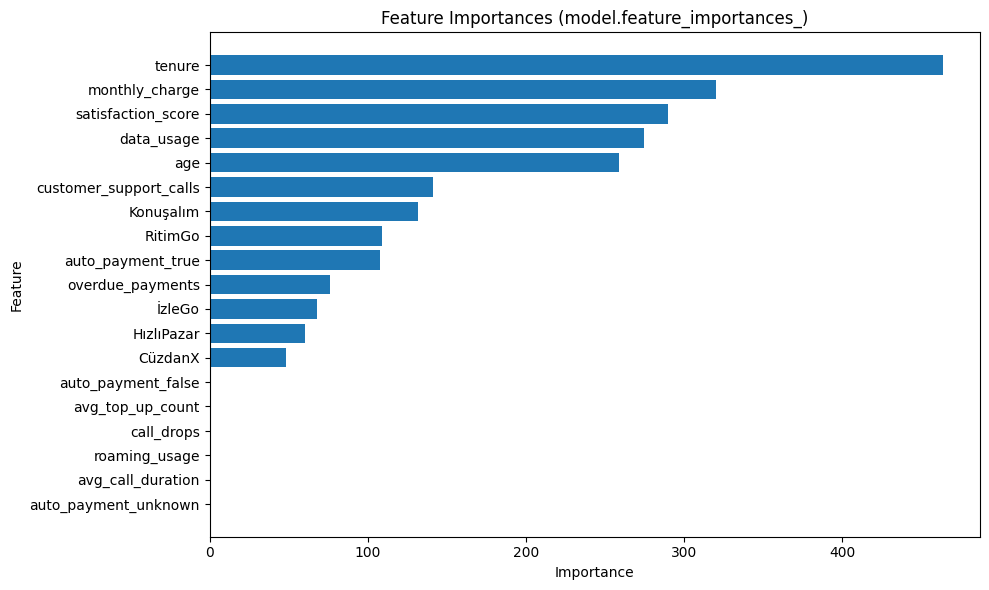

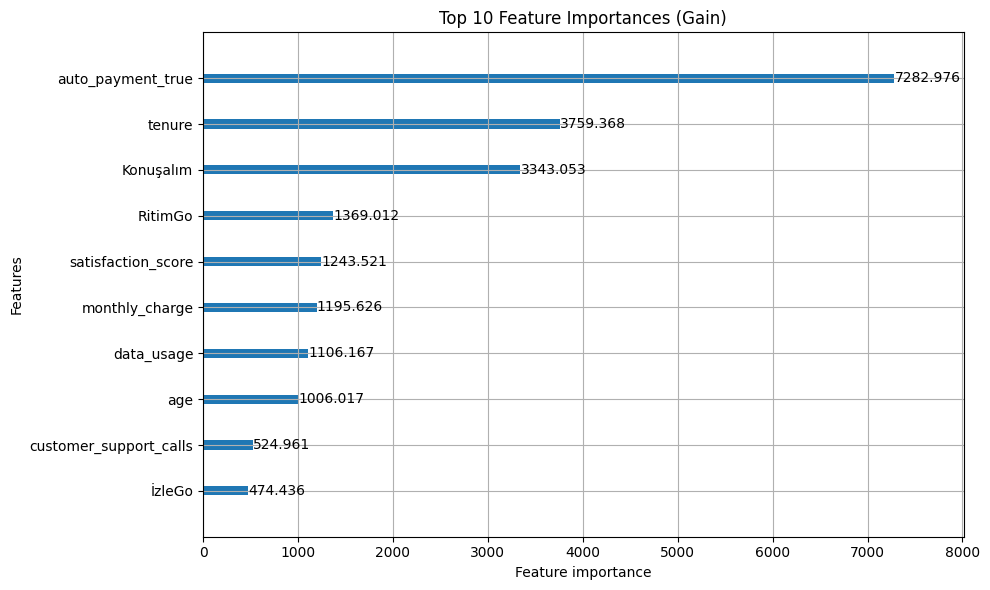


Processing Postpaid Data:
Accuracy: 0.5856947799600882
              precision    recall  f1-score   support

       False       1.00      0.58      0.73    654014
        True       0.04      0.87      0.07     12456

    accuracy                           0.59    666470
   macro avg       0.52      0.73      0.40    666470
weighted avg       0.98      0.59      0.72    666470

F1 Score: 0.07289966894310253
Precision: 0.03804077399098739
Recall: 0.8715478484264612
AUC: 0.784782174544338


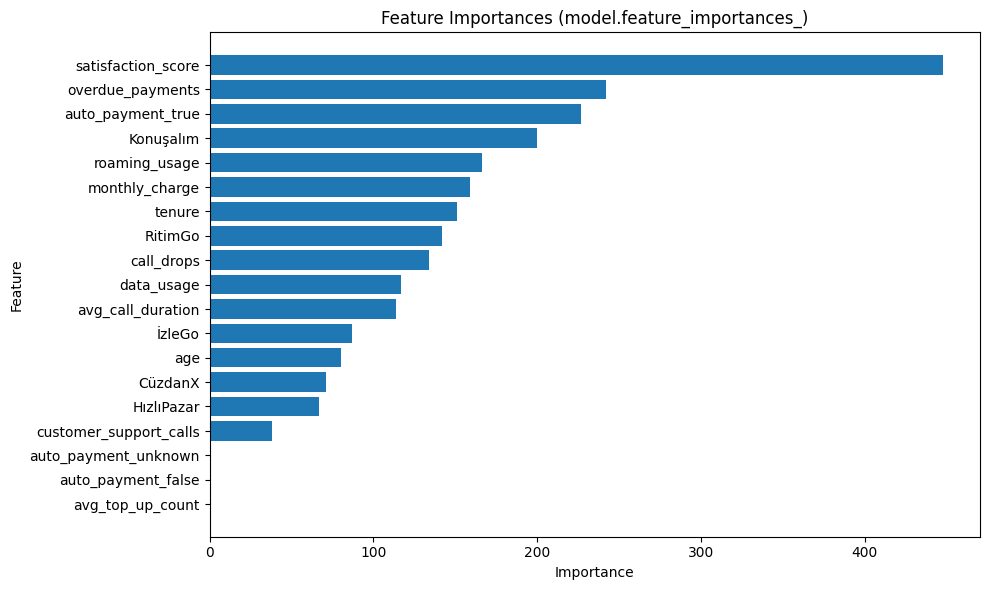

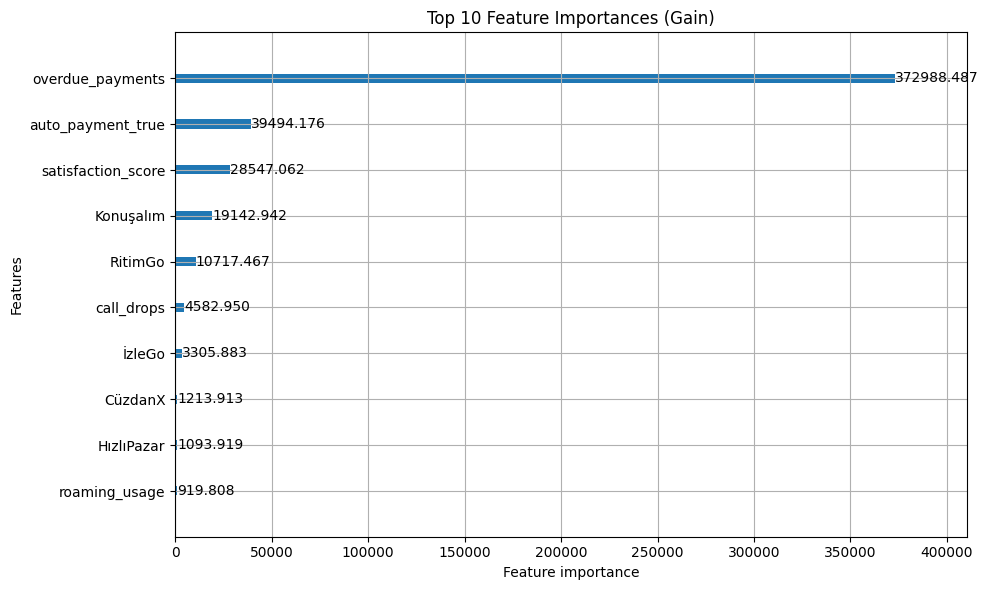


Processing Prepaid Data:
Accuracy: 0.4445525102316987
              precision    recall  f1-score   support

       False       0.99      0.44      0.61    654836
        True       0.03      0.87      0.06     12453

    accuracy                           0.44    667289
   macro avg       0.51      0.65      0.33    667289
weighted avg       0.98      0.44      0.60    667289

F1 Score: 0.05534713018656336
Precision: 0.028580678955639142
Recall: 0.871918413233759
AUC: 0.7109622421525639


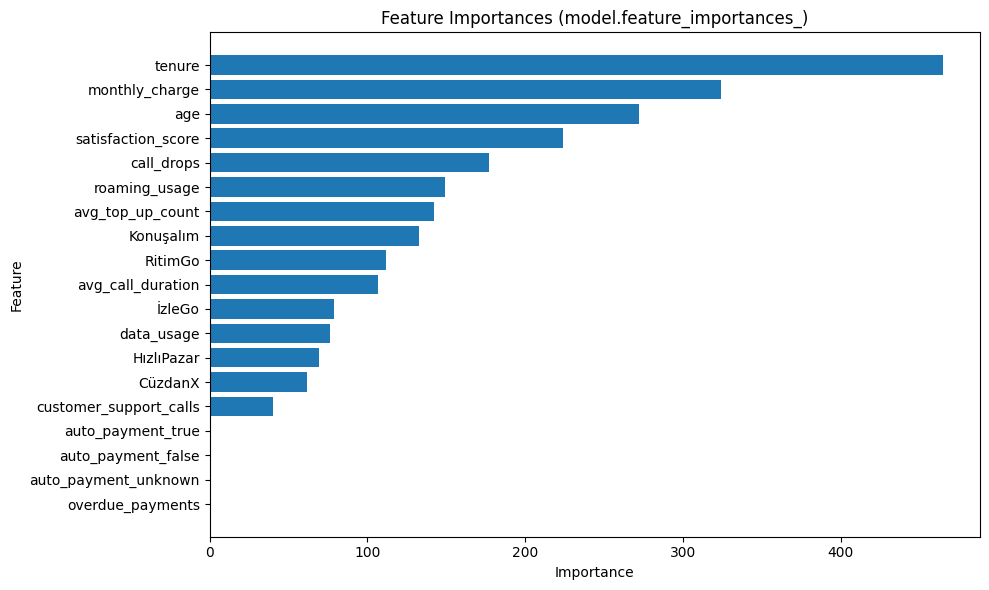

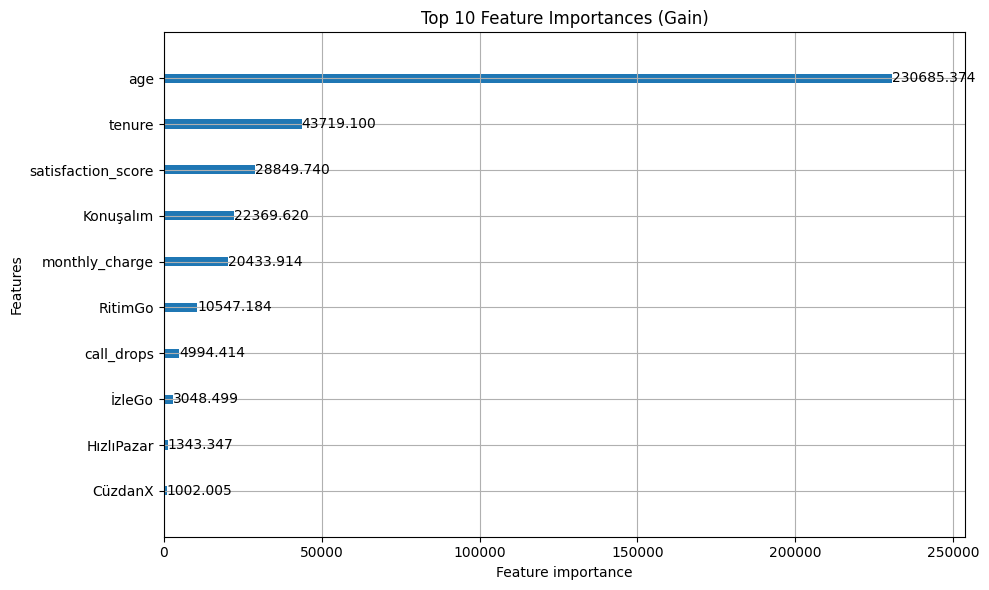

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_score, recall_score, roc_auc_score)
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from lightgbm import LGBMClassifier

def train_and_evaluate(df, target='churn', test_size=0.2, random_state=42,
                       n_estimators=350, learning_rate=0.03, max_depth=3):
    # Separate features and target. The target column is removed from X.
    X = df.drop(columns=[target])
    y = df[target]

    # Split into training and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Apply Random Under Sampling to balance the training data.
    undersampler = RandomUnderSampler(random_state=random_state)
    X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train)

    # -------------------------------
    # Model Training
    # -------------------------------
    model = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
        verbose=-1
    )
    model.fit(X_train_us, y_train_us)

    # -------------------------------
    # Predictions and Evaluation
    # -------------------------------
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_pred_proba))

    # -------------------------------
    # Feature Importance Visualization
    # -------------------------------
    # Option 1: Using model.feature_importances_
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances (model.feature_importances_)")
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.tight_layout()
    plt.show()

    # Option 2: Using LightGBM's built-in plot_importance function
    ax = lgb.plot_importance(
        model.booster_,
        max_num_features=10,
        importance_type='gain',  # alternatively, use 'split'
        figsize=(10, 6),
        title="Top 10 Feature Importances (Gain)"
    )
    plt.tight_layout()
    plt.show()

    return model

# Example usage:
# Assume df_broadband, df_postpaid, and df_prepaid have already been defined.
print("Processing Broadband Data:")
model_broadband = train_and_evaluate(df_broadband)

print("\nProcessing Postpaid Data:")
model_postpaid = train_and_evaluate(df_postpaid)

print("\nProcessing Prepaid Data:")
model_prepaid = train_and_evaluate(df_prepaid)


In [64]:
# # -------------------------------
# # SHAP Analysis Cell
# # -------------------------------
# import shap

# # Optional: if running in a Jupyter Notebook, enable JS visualization
# shap.initjs()

# # Create a SHAP TreeExplainer using the trained model
# explainer = shap.TreeExplainer(model)

# # Compute SHAP values for the test set.
# # Note: For binary classification, this returns a list with two arrays (one per class)
# shap_values = explainer.shap_values(X_test)

# # If working with binary classification, choose the SHAP values for the positive class (index 1)
# if isinstance(shap_values, list) and len(shap_values) == 2:
#     shap_values = shap_values[1]

# # -------------------------------
# # SHAP Summary Dot Plot: Shows the distribution of the impact each feature has on the model output.
# # -------------------------------
# shap.summary_plot(shap_values, X_test)

# # -------------------------------
# # SHAP Summary Bar Plot: Displays the mean absolute value of the SHAP values for each feature, providing a global feature importance.
# # -------------------------------
# shap.summary_plot(shap_values, X_test, plot_type="bar")


In [65]:
df["monthly_charge"].mean()

725.1688532639989

In [66]:
df["tenure"].mean()/12

13.154942441666668

In [67]:
# df = df[df["monthly_charge"] > df["monthly_charge"].mean()]

In [68]:
# --- New Cell ---
# Assume that y_pred and y_pred_proba are already computed as in your previous cell.
# Also assume that X_test is a pandas DataFrame with its original index,
# and that you have a separate DataFrame 'product_df' which includes the columns 'id', 'monthly_charge', and 'churn'.
#
# For example, if you originally had a DataFrame 'df' with these columns, you might have defined:
# product_df = df[['id', 'monthly_charge', 'churn']]

# 1. Create a predictions DataFrame using the index from X_test
predictions_df = pd.DataFrame({
    'predicted_churn': y_pred,            # The binary churn predictions from the model
    'predicted_proba': y_pred_proba         # The predicted probability for churn==True
}, index=X_test.index)

# 2. Filter for rows where the predicted churn is True
churn_true_df = predictions_df[predictions_df['predicted_churn'] == 1]

# 3. Sort the filtered rows by the predicted probability (highest first)
churn_true_df = churn_true_df.sort_values(by='predicted_proba', ascending=False)

# print("Churn==True predictions (without additional product info):")
# display(churn_true_df)

# 4. Merge with product_df to include id and monthly_charge.
# Here we assume that product_df has its index aligned with X_test.
# If not, you will need to ensure there is a common key to merge on.
merged_churn_df = product_df.loc[churn_true_df.index].copy()
merged_churn_df = merged_churn_df.join(churn_true_df)

# 5. Filter rows where monthly_charge is greater than the overall mean.
# If df is your original DataFrame, then:
mean_monthly_charge = df["monthly_charge"].mean()
filtered_merged_churn_df = merged_churn_df[merged_churn_df["monthly_charge"] > mean_monthly_charge]

print("Merged DataFrame with product info, predictions, and monthly_charge > mean:")
call_capacity = 100000
filtered_merged_churn_df = filtered_merged_churn_df.sort_values(by='monthly_charge', ascending=False)[:call_capacity]  ## PARAMETER 1
display(filtered_merged_churn_df)

tp_count = filtered_merged_churn_df[filtered_merged_churn_df["churn"] == 1].shape[0]
fp_count = filtered_merged_churn_df[filtered_merged_churn_df["churn"] == 0].shape[0]

cost_per_call =  5 ## PARAMETER 2 AS COST PER CALL
call_cost_m = cost_per_call*100_000/1_000_000

savings_monthly = filtered_merged_churn_df.loc[filtered_merged_churn_df["churn"] == 1, "monthly_charge"].sum()
savings_monthly_m = round(savings_monthly/1_000_000, 3)

print(f"Doğru arama: {tp_count}, \nBoşa arama: {fp_count},\nKurtarılan aylık gelir:  {savings_monthly_m} Milyon TL / Ay\nArama masrafı: {call_cost_m} Milyon TL (Tek seferlik)")



NameError: name 'y_pred' is not defined